# Salary prediction model for programmers
## Structure of the code
1. Data exploration
2. Fit regression full model (with all available columns)
3. Fit regression partial model (after grouping)<br>
4. **Interesting observations**

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("survey_results_public.csv",low_memory=False)
data.shape

(98855, 129)

In [2]:
# group country
country_list = list(data['Country'])
developed_country = ['United States','Japan','Turkey','Germany','United Kingdom','France','Italy','South Korea','Spain','Canada','Australia','Netherlands','Belgium','Greece','Czech Republic','Portugal','Sweden','Austria','Switzerland','Israel','Singapore','Denmark','Finland','Norway','Ireland','New Zealand','Slovenia','Estonia','Cyprus','Luxembourg','Iceland']
developing_country = []
for country in country_list:
    if country not in developed_country:
        developing_country.append(country)
mapping = {}
for country in country_list:
    if country in developed_country:
        mapping.update({country: "developed_country"})
    else:
        mapping.update({country: "developing_country"})
# df['Country'].replace(mapping)
data['Country'] = data['Country'].replace(mapping)
data.shape

(98855, 129)

In [3]:
# Redundant columns
DROP_COLUMNS = ['CurrencySymbol','Salary', 'SalaryType', 'Respondent', 'Currency']

data.drop(DROP_COLUMNS, axis=1, inplace=True)
df=data[data['ConvertedSalary'].notnull()][:]
df.shape

(47702, 124)

In [4]:
# remove outliers
Q1 = df['ConvertedSalary'].quantile(0.25)
Q3 = df['ConvertedSalary'].quantile(0.75)
IQR = Q3 - Q1
drop_outliers = []
for i in df['ConvertedSalary'].index:
    if df['ConvertedSalary'][i] < Q1 - 1.5*IQR or df['ConvertedSalary'][i] > Q3 + 1.5*IQR:
        drop_outliers.append(i)
df.drop(drop_outliers, inplace = True)
df.shape

(45069, 124)

In [5]:
DROP_COLUMNS = [
'AssessJob1','AssessJob2','AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10',
'AssessBenefits1','AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7',
'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10', 'AssessBenefits11',
'JobContactPriorities1', 'JobContactPriorities2', 'JobContactPriorities3', 'JobContactPriorities4', 'JobContactPriorities5',
'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4','JobEmailPriorities5', 'JobEmailPriorities6',
'JobEmailPriorities7',
'AdsPriorities1', 'AdsPriorities2', 'AdsPriorities3', 'AdsPriorities4', 'AdsPriorities5', 'AdsPriorities6', 'AdsPriorities7',
'AIDangerous','AIInteresting','AIResponsible','AIFuture',
'EthicsChoice','EthicsReport','EthicsResponsible','EthicalImplications',
'FrameworkDesireNextYear','LanguageDesireNextYear','DatabaseDesireNextYear','PlatformDesireNextYear',
'SurveyTooLong','SurveyEasy',
'HypotheticalTools1','HypotheticalTools2','HypotheticalTools3','HypotheticalTools4','HypotheticalTools5',
'AdsAgreeDisagree1', 'AdsAgreeDisagree2', 'AdsAgreeDisagree3',
'StackOverflowRecommend','StackOverflowVisit','StackOverflowHasAccount','StackOverflowParticipate','StackOverflowJobs','StackOverflowDevStory',
'StackOverflowJobsRecommend','StackOverflowConsiderMember',
'AdsActions','AdBlockerReasons','AgreeDisagree1','AgreeDisagree2','AgreeDisagree3','JobSatisfaction','CareerSatisfaction','HopeFiveYears',
'UpdateCV','HackathonReasons','AdBlocker','AdBlockerDisable','AdBlockerReasons','AdsActions'
]

df_part = df.drop(DROP_COLUMNS, axis=1,inplace = False)
df_part.shape

(45069, 42)

## 4.1. Common important features

In [6]:
def Boxplot(catogory,size):
    DF = df[df[catogory].notnull()]
    DF.boxplot('ConvertedSalary',by = catogory,figsize=size)

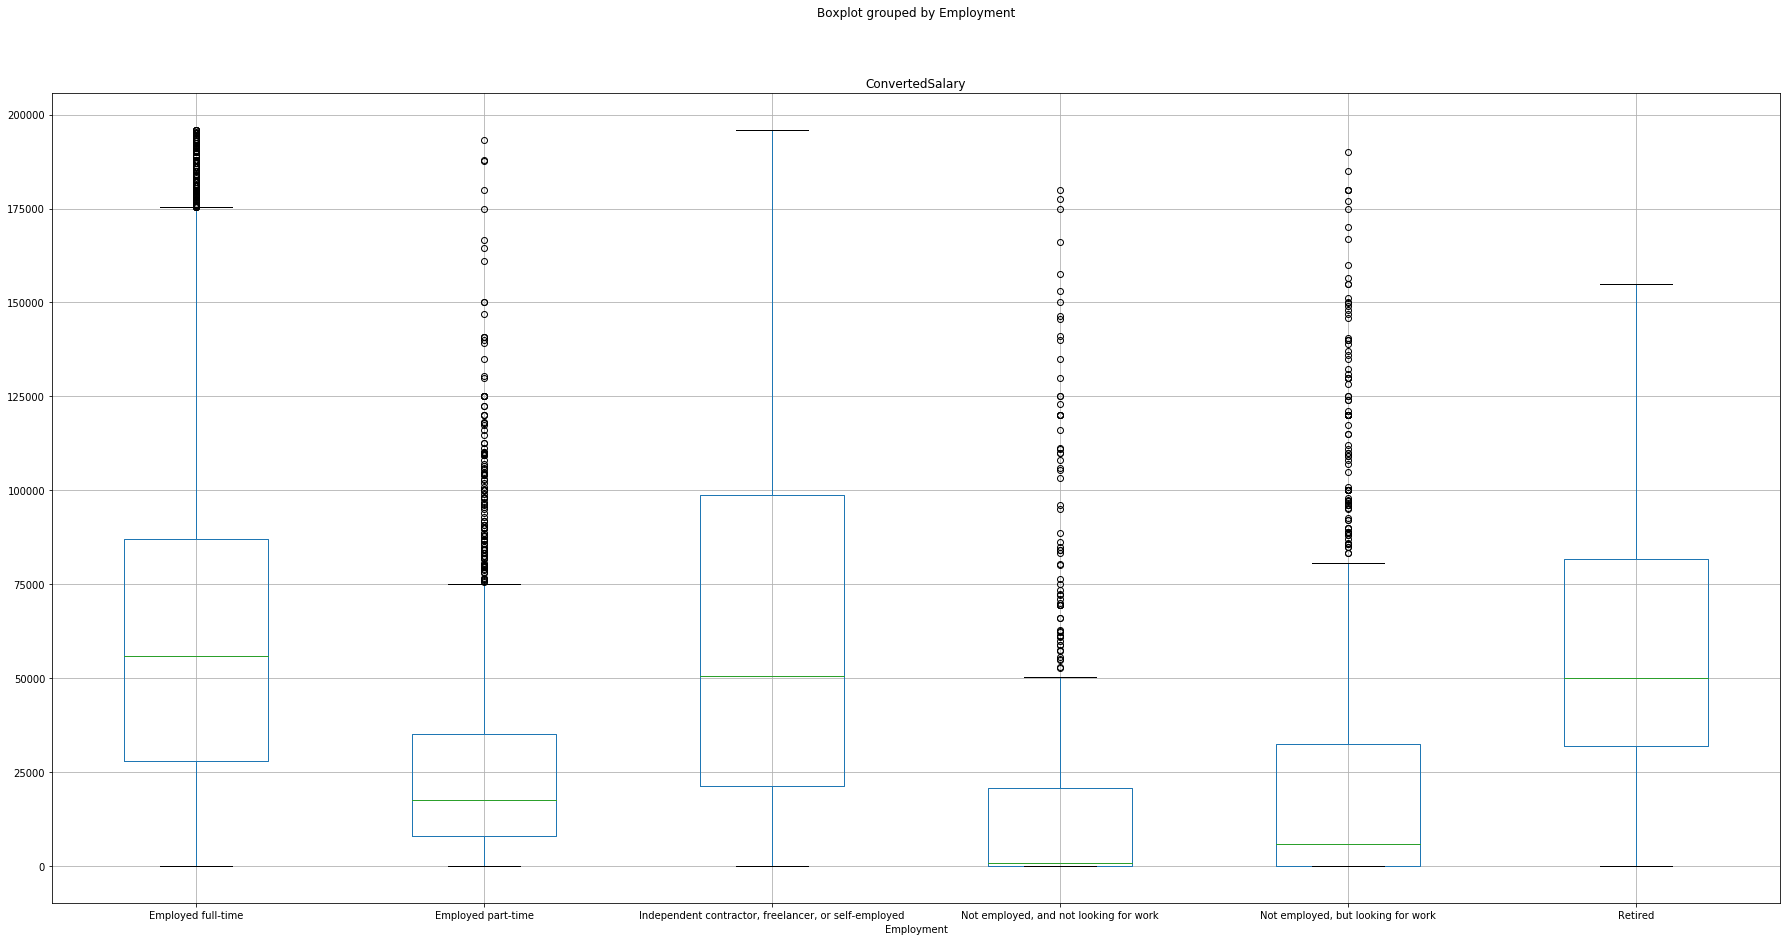

In [7]:
Boxplot('Employment',(30,15))

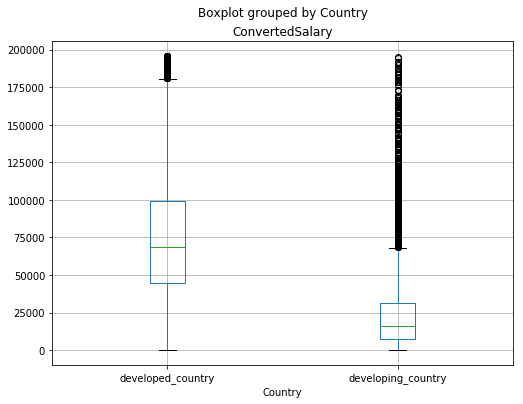

In [8]:
Boxplot('Country',(8,6))

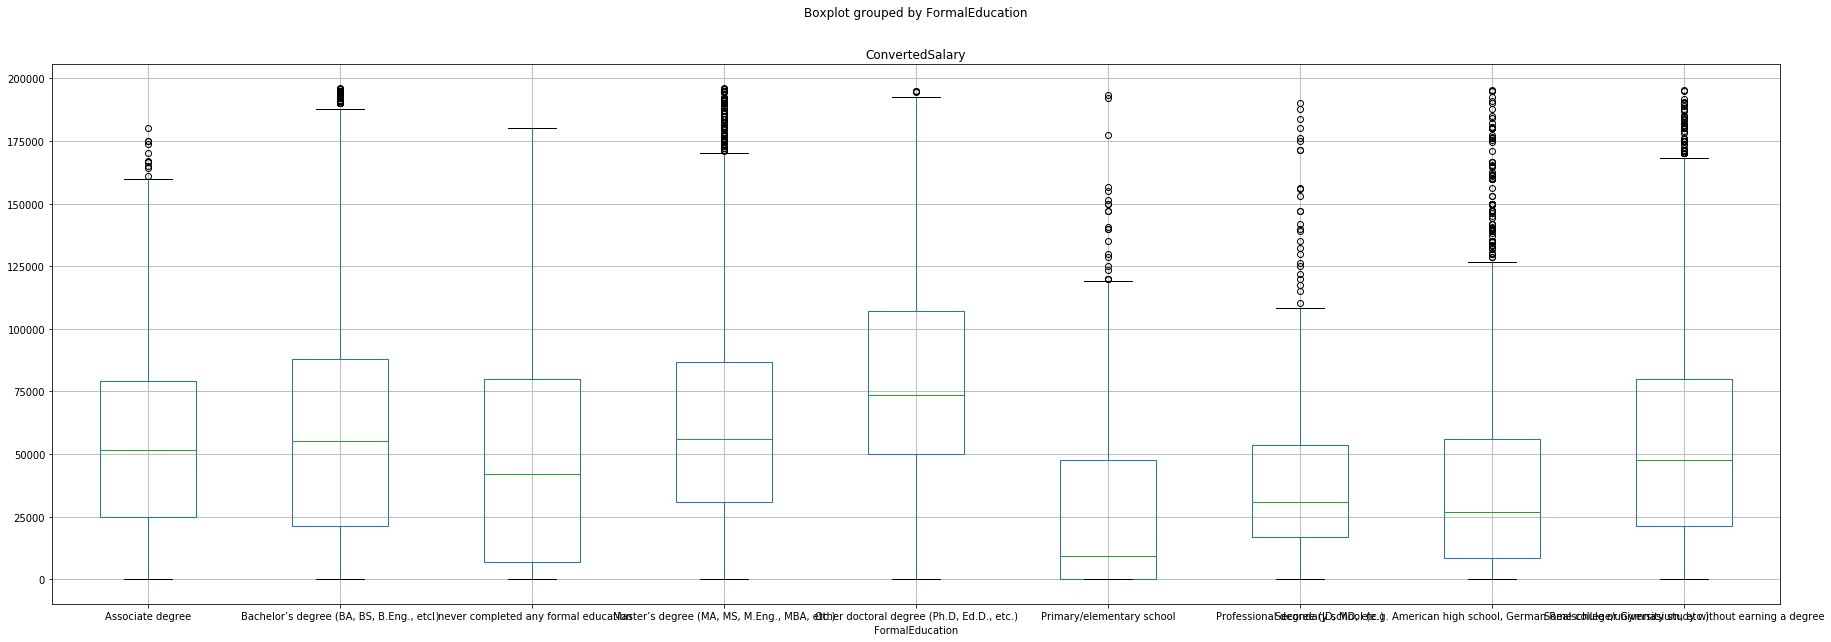

In [9]:
Boxplot('FormalEducation',(30,10))

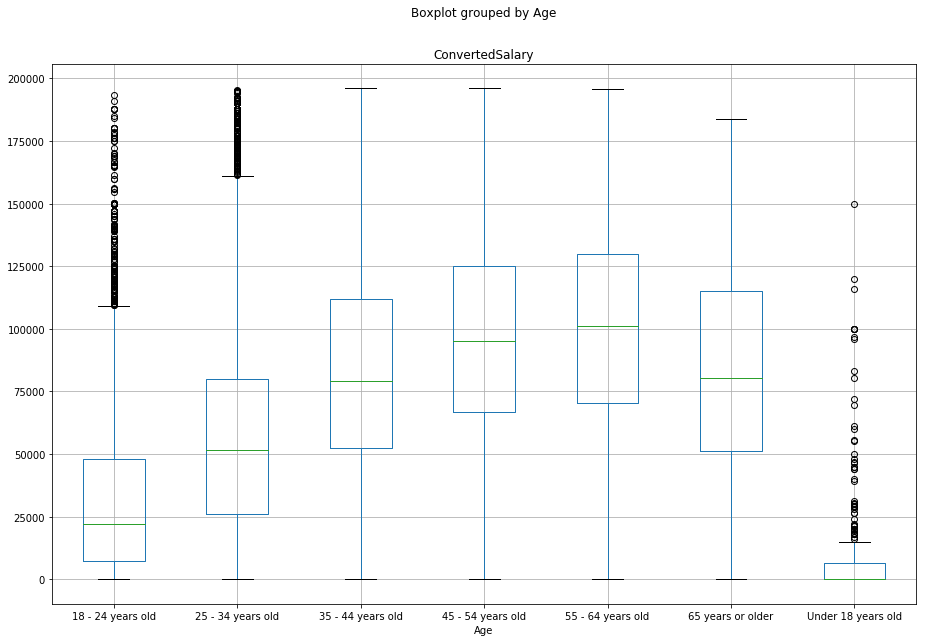

In [10]:
Boxplot('Age',(15,10))

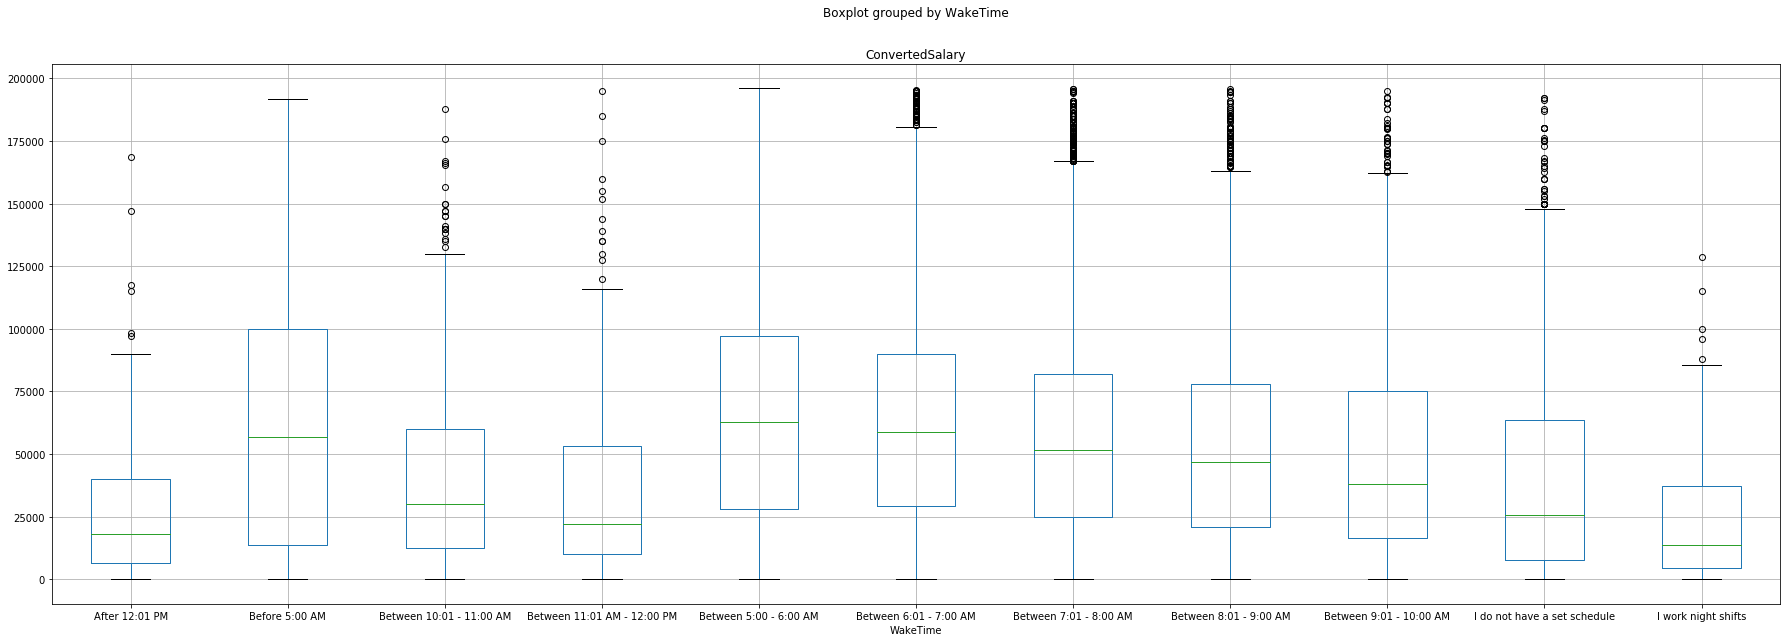

In [11]:
Boxplot('WakeTime',(30,10))

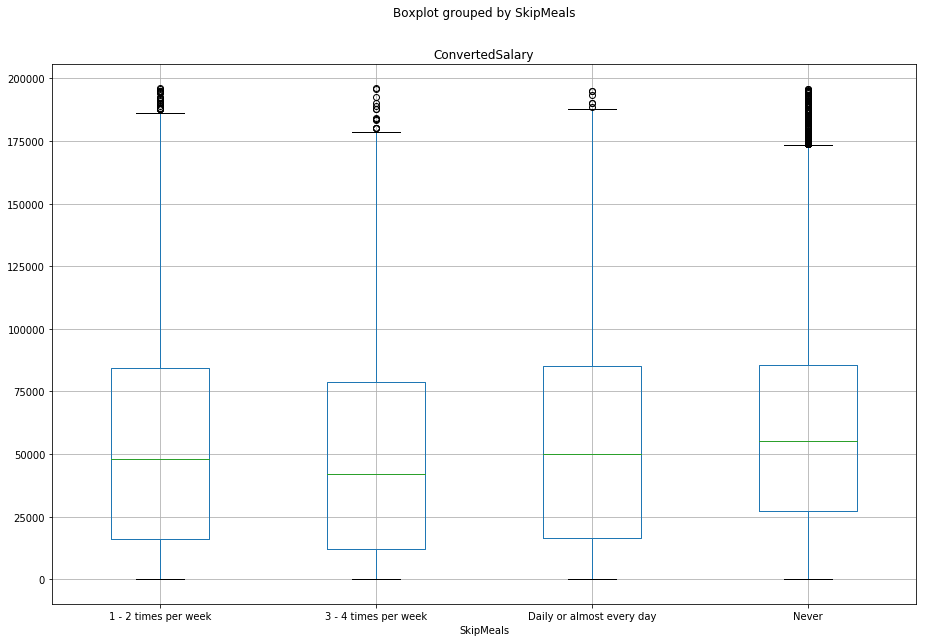

In [12]:
Boxplot('SkipMeals',(15,10))

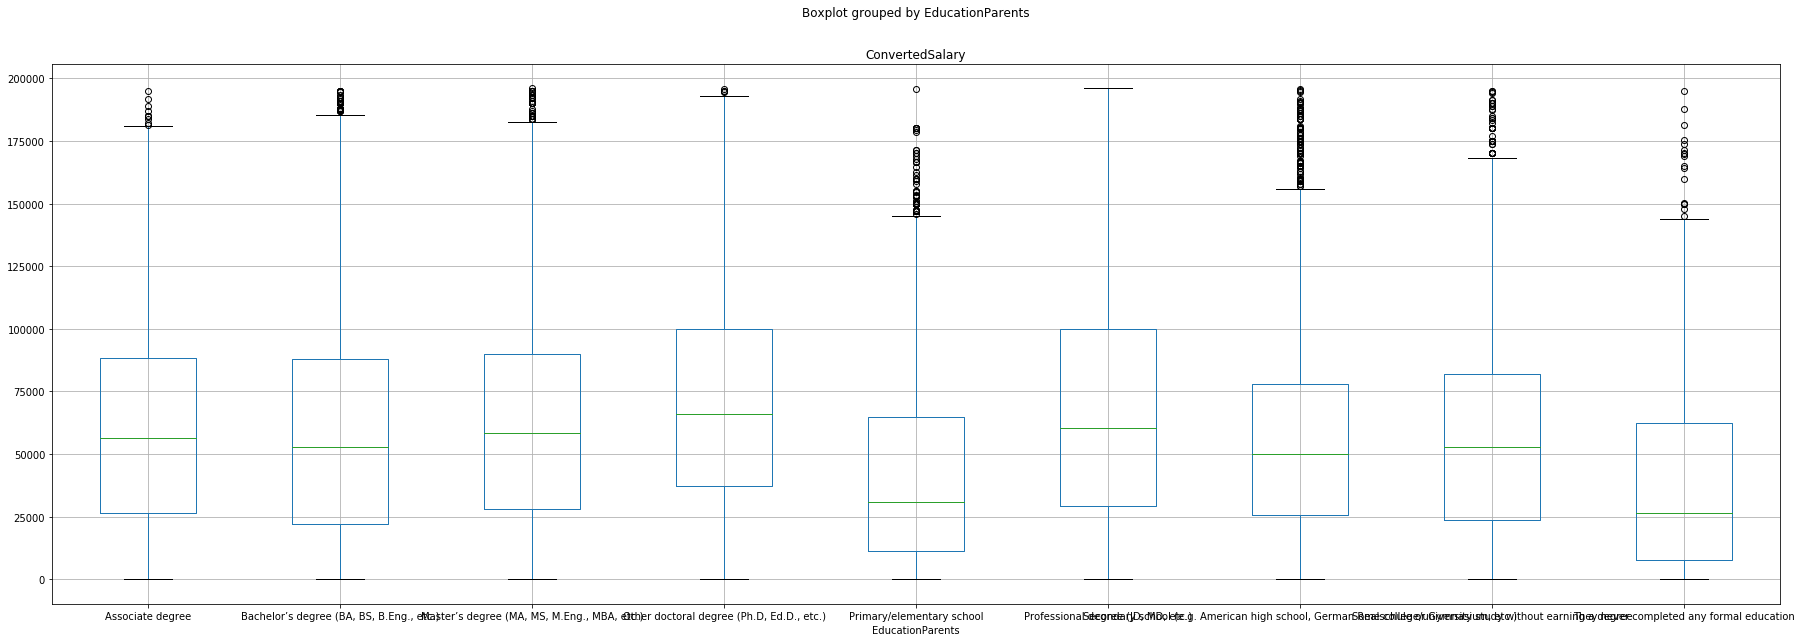

In [13]:
Boxplot('EducationParents',(30,10))

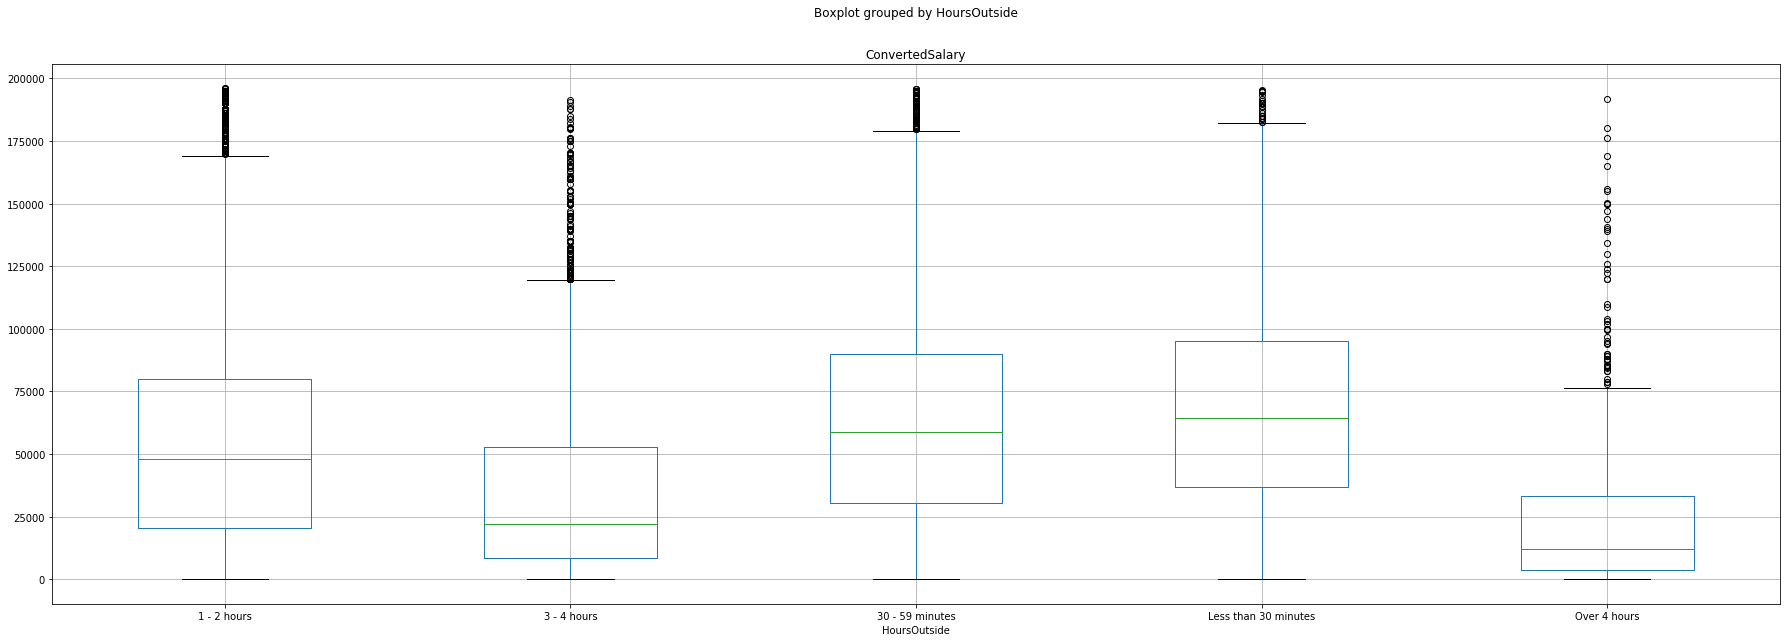

In [14]:
Boxplot('HoursOutside',(30,10))

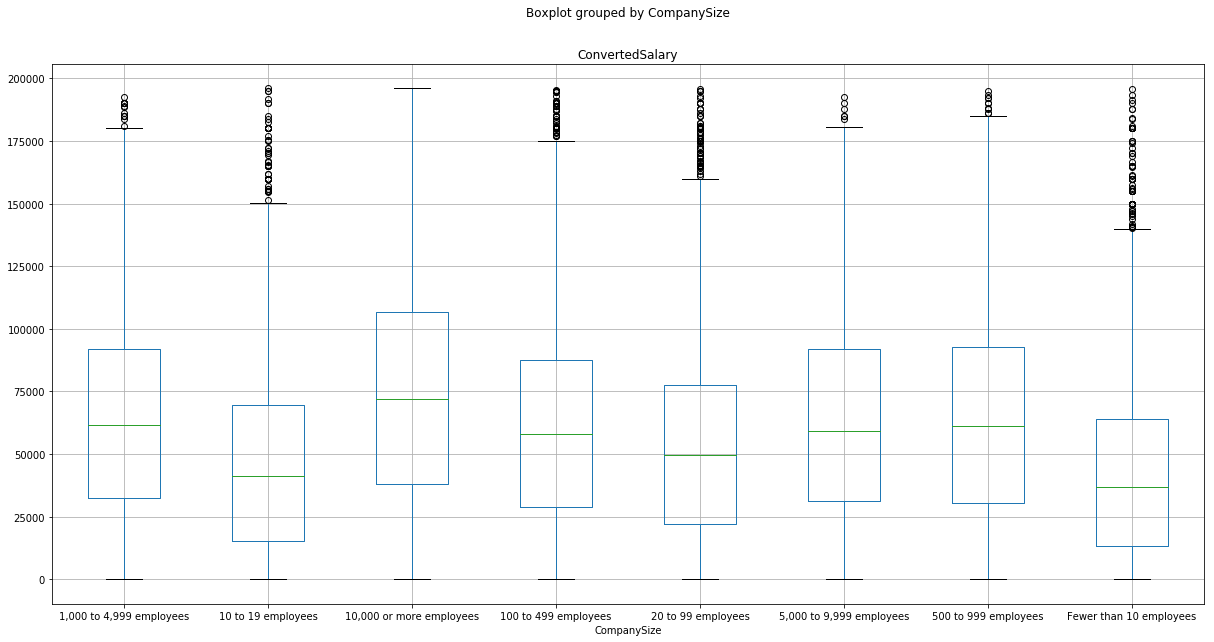

In [15]:
Boxplot('CompanySize',(20,10))

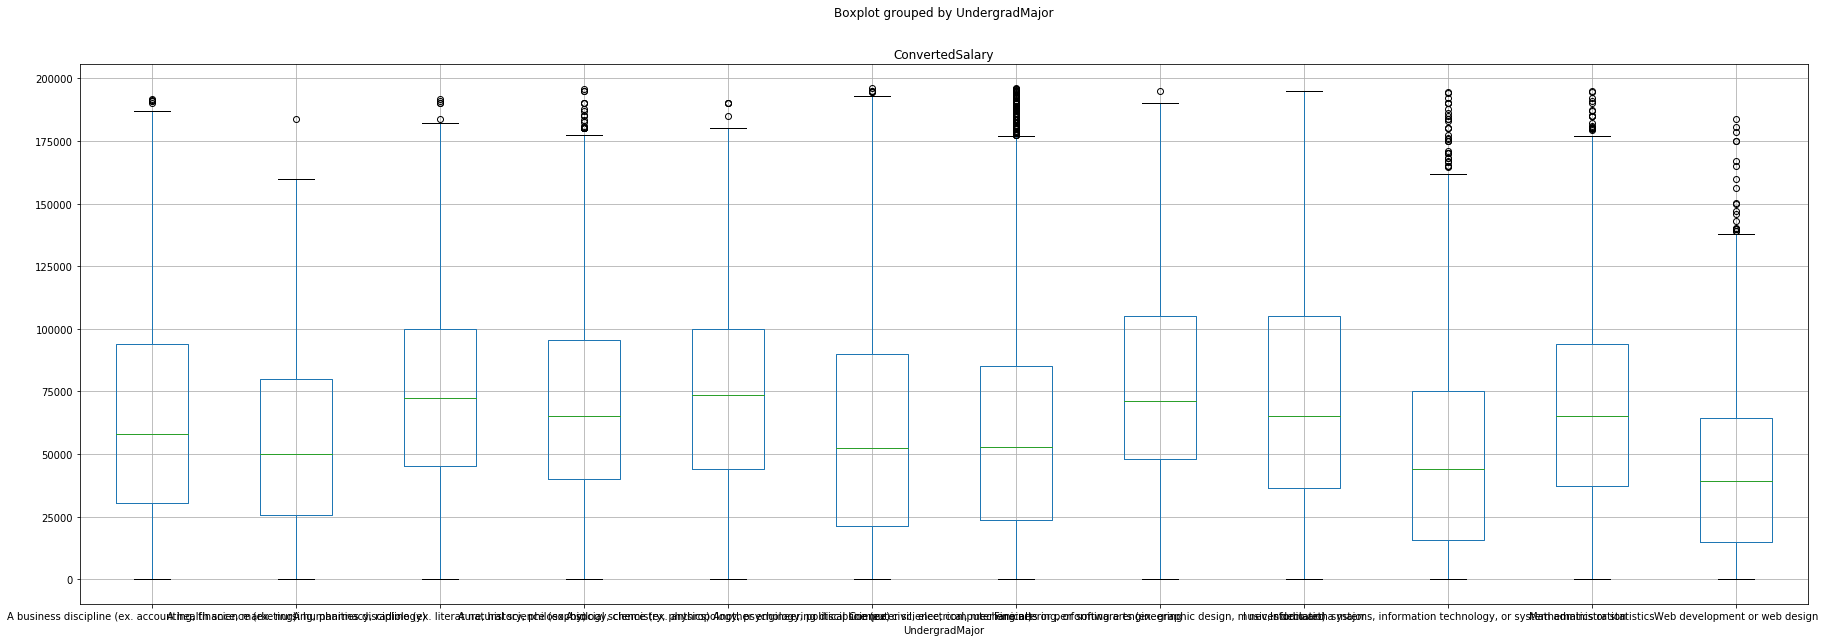

In [16]:
Boxplot('UndergradMajor',(30,10))

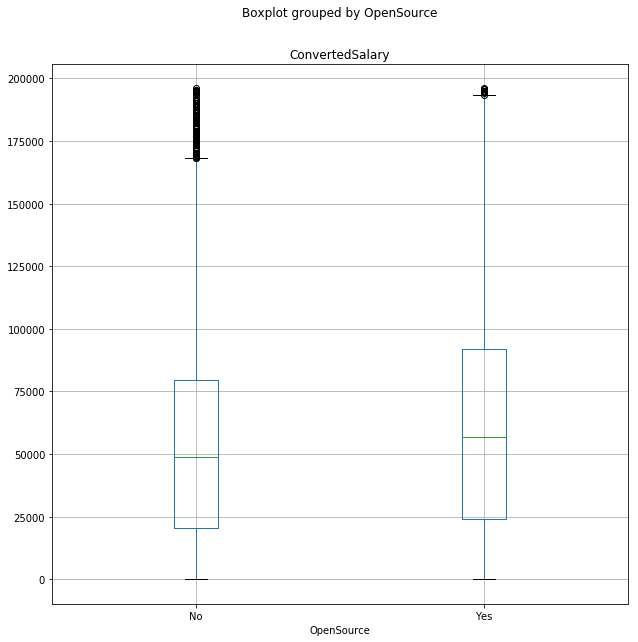

In [17]:
Boxplot('OpenSource',(10,10))

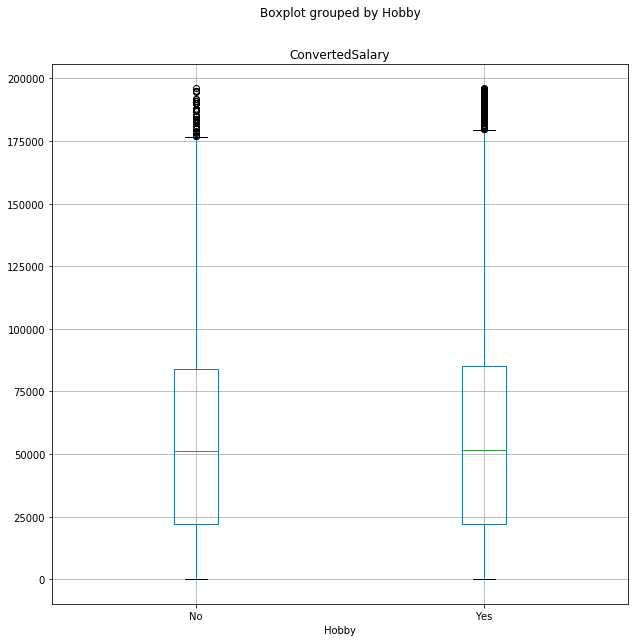

In [18]:
Boxplot('Hobby',(10,10))

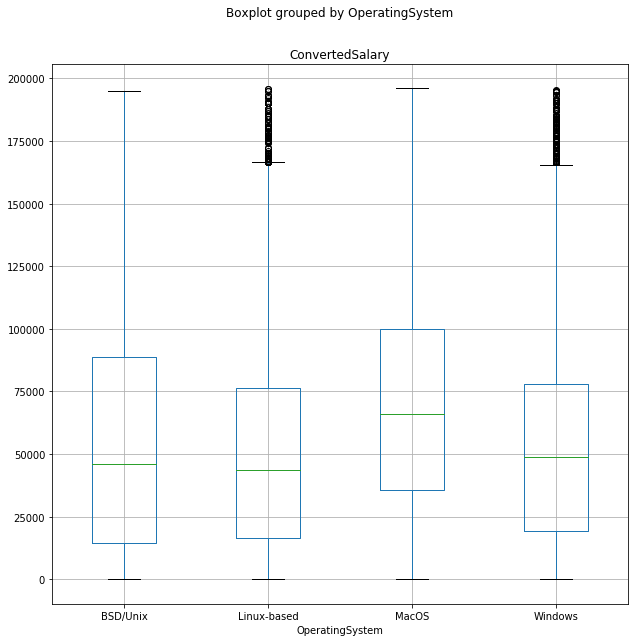

In [19]:
Boxplot('OperatingSystem',(10,10))

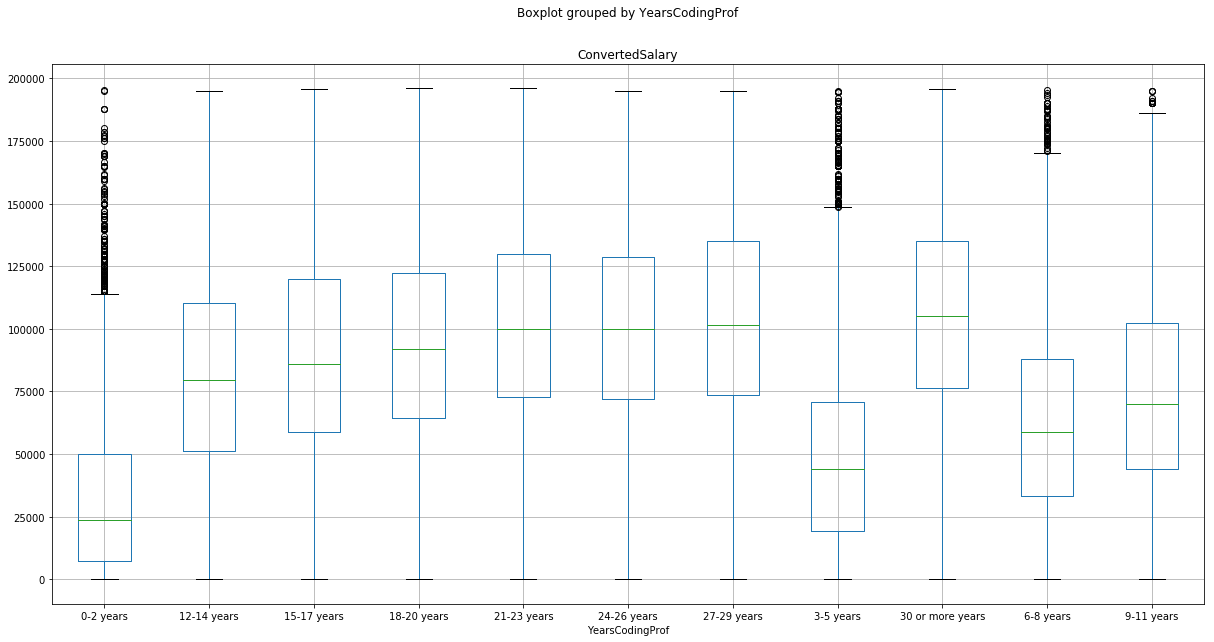

In [20]:
Boxplot('YearsCodingProf',(20,10))

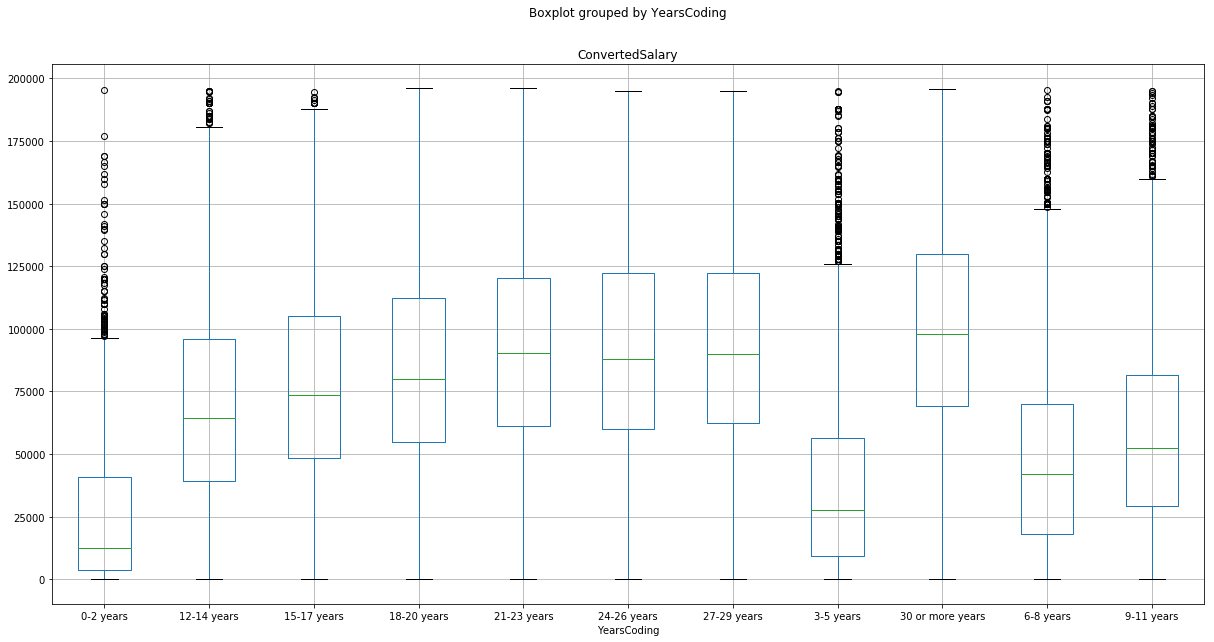

In [21]:
Boxplot('YearsCoding',(20,10))

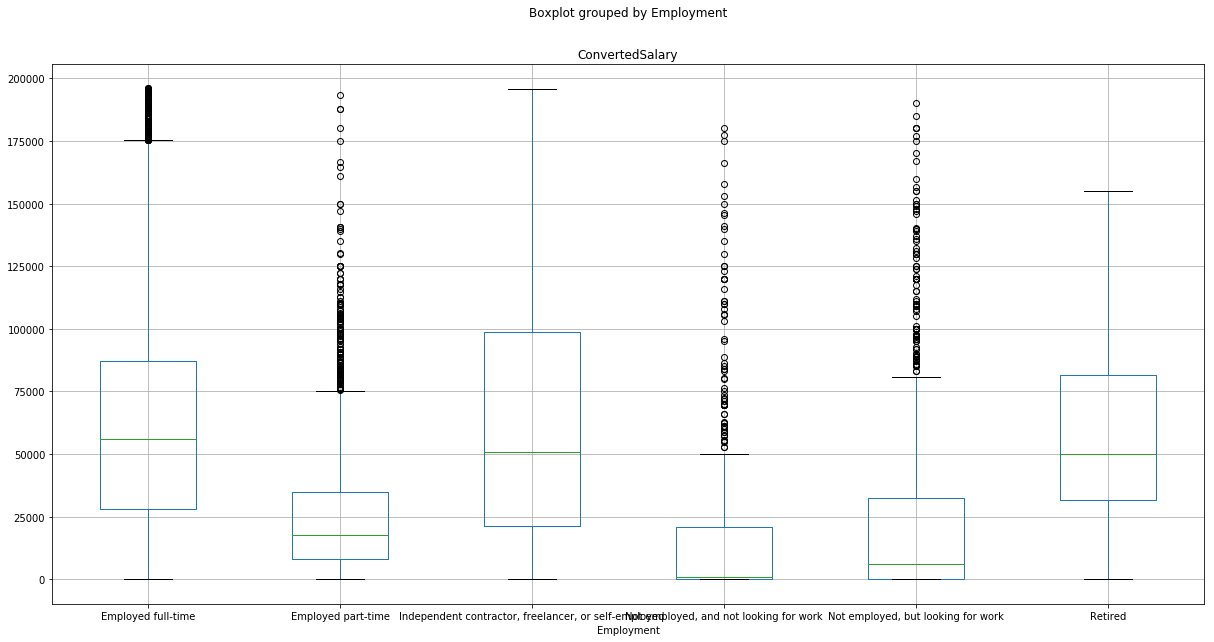

In [22]:
Boxplot('Employment',(20,10))

In [23]:
MULTIPLE_CHOICE = [ # for full model
    'DevType','IDE', 'FrameworkWorkedWith',
    'CommunicationTools','EducationTypes','SelfTaughtTypes','HackathonReasons', 
    'DatabaseWorkedWith','PlatformWorkedWith',
    'Methodology','VersionControl',
    'ErgonomicDevices','Gender',
    'SexualOrientation','RaceEthnicity', 
    'LanguageWorkedWith','FrameworkDesireNextYear','LanguageDesireNextYear','DatabaseDesireNextYear','PlatformDesireNextYear',
    'AdsActions','AdBlockerReasons'
]

# Go through all object columns
for c in MULTIPLE_CHOICE:
    
    # Check if there are multiple entries in this column
    temp = df[c].str.split(';', expand=True)

    # Get all the possible values in this column
    new_columns = pd.unique(temp.values.ravel())
    for new_c in new_columns:
        if new_c and new_c is not np.nan:
            
            # Create new column for each unique column
            idx = df[c].str.contains(new_c, regex=False).fillna(False)
            df.loc[idx, f"{c}_{new_c}"] = 1

    # Info to the user
    print(f">> Multiple entries in {c}. Added {len(new_columns)} one-hot-encoding columns")

    # Drop the original column
    df.drop(c, axis=1, inplace=True)
        
# For all the remaining categorical columns, create dummy columns
df = pd.get_dummies(df)
df.shape

MULTIPLE_CHOICE = [ # for partial model
    'DevType','IDE', 'FrameworkWorkedWith',
    'CommunicationTools','EducationTypes','SelfTaughtTypes',
    'DatabaseWorkedWith','PlatformWorkedWith',
    'Methodology','VersionControl',
    'ErgonomicDevices','Gender',
    'SexualOrientation','RaceEthnicity', 
    'LanguageWorkedWith'
]

# Go through all object columns
for c in MULTIPLE_CHOICE:
    
    # Check if there are multiple entries in this column
    temp = df_part[c].str.split(';', expand=True)

    # Get all the possible values in this column
    new_columns = pd.unique(temp.values.ravel())
    for new_c in new_columns:
        if new_c and new_c is not np.nan:
            
            # Create new column for each unique column
            idx = df_part[c].str.contains(new_c, regex=False).fillna(False)
            df_part.loc[idx, f"{c}_{new_c}"] = 1

    # Info to the user
    print(f">> Multiple entries in {c}. Added {len(new_columns)} one-hot-encoding columns")

    # Drop the original column
    df_part.drop(c, axis=1, inplace=True)
        
# For all the remaining categorical columns, create dummy columns
df_part = pd.get_dummies(df_part)
df_part.shape

def fillna(df):
    df.dropna(axis=1, how='all', inplace=True)
    dummy_columns = [c for c in df.columns if len(df[c].unique()) == 2]
    non_dummy = [c for c in df.columns if c not in dummy_columns]
    df[dummy_columns] = df[dummy_columns].fillna(0)
    df[non_dummy] = df[non_dummy].fillna(df[non_dummy].median())

    print(f">> Filled NaNs in {len(dummy_columns)} OHE columns with 0")
    print(f">> Filled NaNs in {len(non_dummy)} non-OHE columns with median values")

fillna(df)
fillna(df_part)

developed = df[df['Country_developed_country'] == 1]
developing = df[df['Country_developed_country'] != 1]

>> Multiple entries in DevType. Added 22 one-hot-encoding columns
>> Multiple entries in IDE. Added 24 one-hot-encoding columns
>> Multiple entries in FrameworkWorkedWith. Added 14 one-hot-encoding columns
>> Multiple entries in CommunicationTools. Added 13 one-hot-encoding columns
>> Multiple entries in EducationTypes. Added 11 one-hot-encoding columns
>> Multiple entries in SelfTaughtTypes. Added 11 one-hot-encoding columns
>> Multiple entries in HackathonReasons. Added 9 one-hot-encoding columns
>> Multiple entries in DatabaseWorkedWith. Added 23 one-hot-encoding columns
>> Multiple entries in PlatformWorkedWith. Added 28 one-hot-encoding columns
>> Multiple entries in Methodology. Added 12 one-hot-encoding columns
>> Multiple entries in VersionControl. Added 9 one-hot-encoding columns
>> Multiple entries in ErgonomicDevices. Added 6 one-hot-encoding columns
>> Multiple entries in Gender. Added 6 one-hot-encoding columns
>> Multiple entries in SexualOrientation. Added 6 one-hot-enco

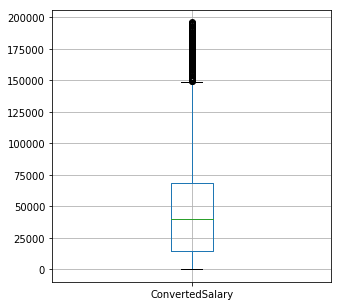

In [24]:
yes = df[df['LanguageWorkedWith_PHP'] == 1]
no = df[df['LanguageWorkedWith_PHP'] != 1]
yes.boxplot('ConvertedSalary',figsize = (5,5))

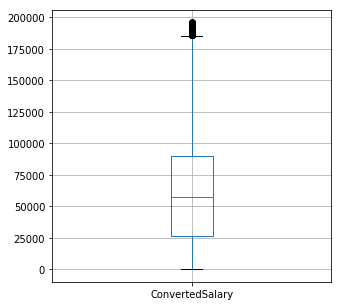

In [25]:
no.boxplot('ConvertedSalary',figsize = (5,5))

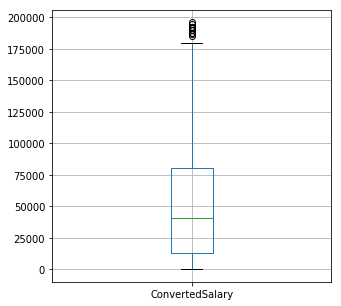

In [26]:
yes = df[df['RaceEthnicity_East Asian'] == 1]
no = df[df['RaceEthnicity_East Asian'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

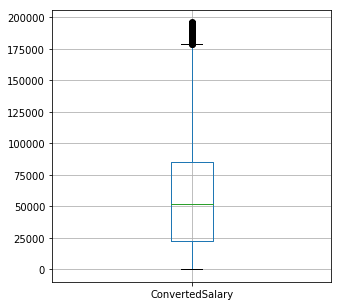

In [27]:
no.boxplot('ConvertedSalary',figsize = (5,5))

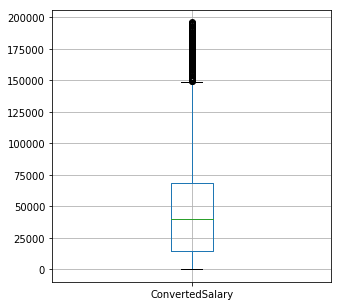

In [28]:
yes = df[df['LanguageWorkedWith_PHP'] == 1]
no = df[df['LanguageWorkedWith_PHP'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

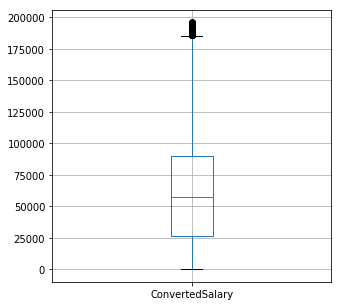

In [29]:
no.boxplot('ConvertedSalary',figsize = (5,5))

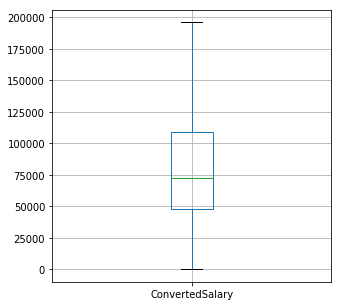

In [30]:
yes = developed[developed['RaceEthnicity_East Asian'] == 1]
no = developed[developed['RaceEthnicity_East Asian'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

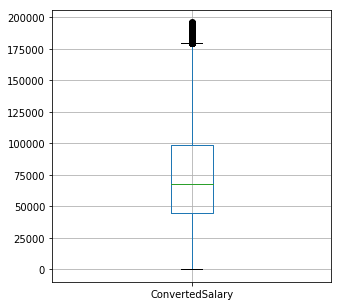

In [31]:
no.boxplot('ConvertedSalary',figsize = (5,5))

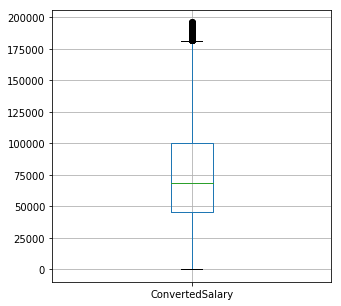

In [32]:
yes = developed[developed['RaceEthnicity_White or of European descent'] == 1]
no = developed[developed['RaceEthnicity_White or of European descent'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

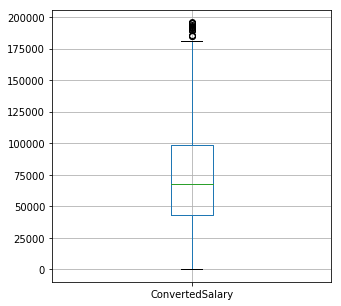

In [33]:
no.boxplot('ConvertedSalary',figsize = (5,5))

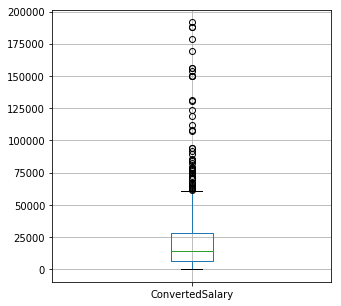

In [34]:
yes = developing[developing['RaceEthnicity_East Asian'] == 1]
no = developing[developing['RaceEthnicity_East Asian'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

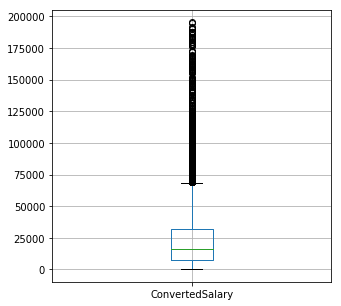

In [35]:
no.boxplot('ConvertedSalary',figsize = (5,5))

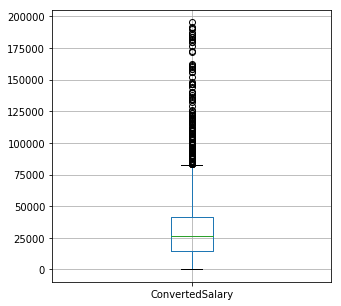

In [36]:
yes = developing[developing['RaceEthnicity_White or of European descent'] == 1]
no = developing[developing['RaceEthnicity_White or of European descent'] != 1]

yes.boxplot('ConvertedSalary',figsize = (5,5))

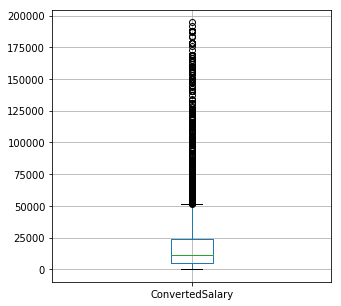

In [37]:
no.boxplot('ConvertedSalary',figsize = (5,5))